In [43]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms as T
import time
from matplotlib.patches import Rectangle
import json

#data_path = "/run/media/kevin/Volume/OpenImages/"
data_path = "/home/kevin/deep_learning/wildcam_eccv/"

In [3]:
# Load training annotation
train_anno_path = "/home/kevin/deep_learning/wildcam_eccv/eccv_18_annotation_files/train_annotations.json"
train_anno = json.load(open(train_anno_path))

In [7]:
df = pd.DataFrame.from_dict(train_anno['annotations'])
df.head()

image_id  category_id  \
0  5a197af2-23d2-11e8-a6a3-ec086b02610b           10   
1  59fc7e52-23d2-11e8-a6a3-ec086b02610b           16   
2  5a2e130d-23d2-11e8-a6a3-ec086b02610b           10   
3  598ad0cf-23d2-11e8-a6a3-ec086b02610b            8   
4  598ad0cf-23d2-11e8-a6a3-ec086b02610b            8   

                                                bbox     id  
0  [317.44, 747.52, 261.11999999999995, 284.15999...  19688  
1           [0.0, 660.48, 381.44, 273.9200000000001]  43259  
2                    [1397.76, 458.24, 192.0, 192.0]  10268  
3  [989.44, 759.04, 262.4000000000001, 390.400000...   2721  
4       [33.28, 1118.72, 583.68, 375.03999999999996]   2722

In [21]:
images = list(df['image_id'])
root_dir = os.path.join(data_path, "eccv_18_cropped")

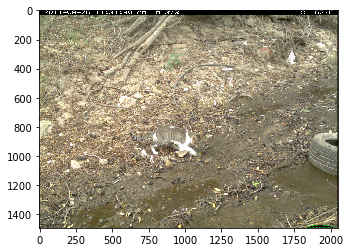

In [54]:
idx = 2098
img_path = os.path.join(root_dir, images[idx]+ ".jpg")
img = Image.open(img_path)
plt.imshow(img)

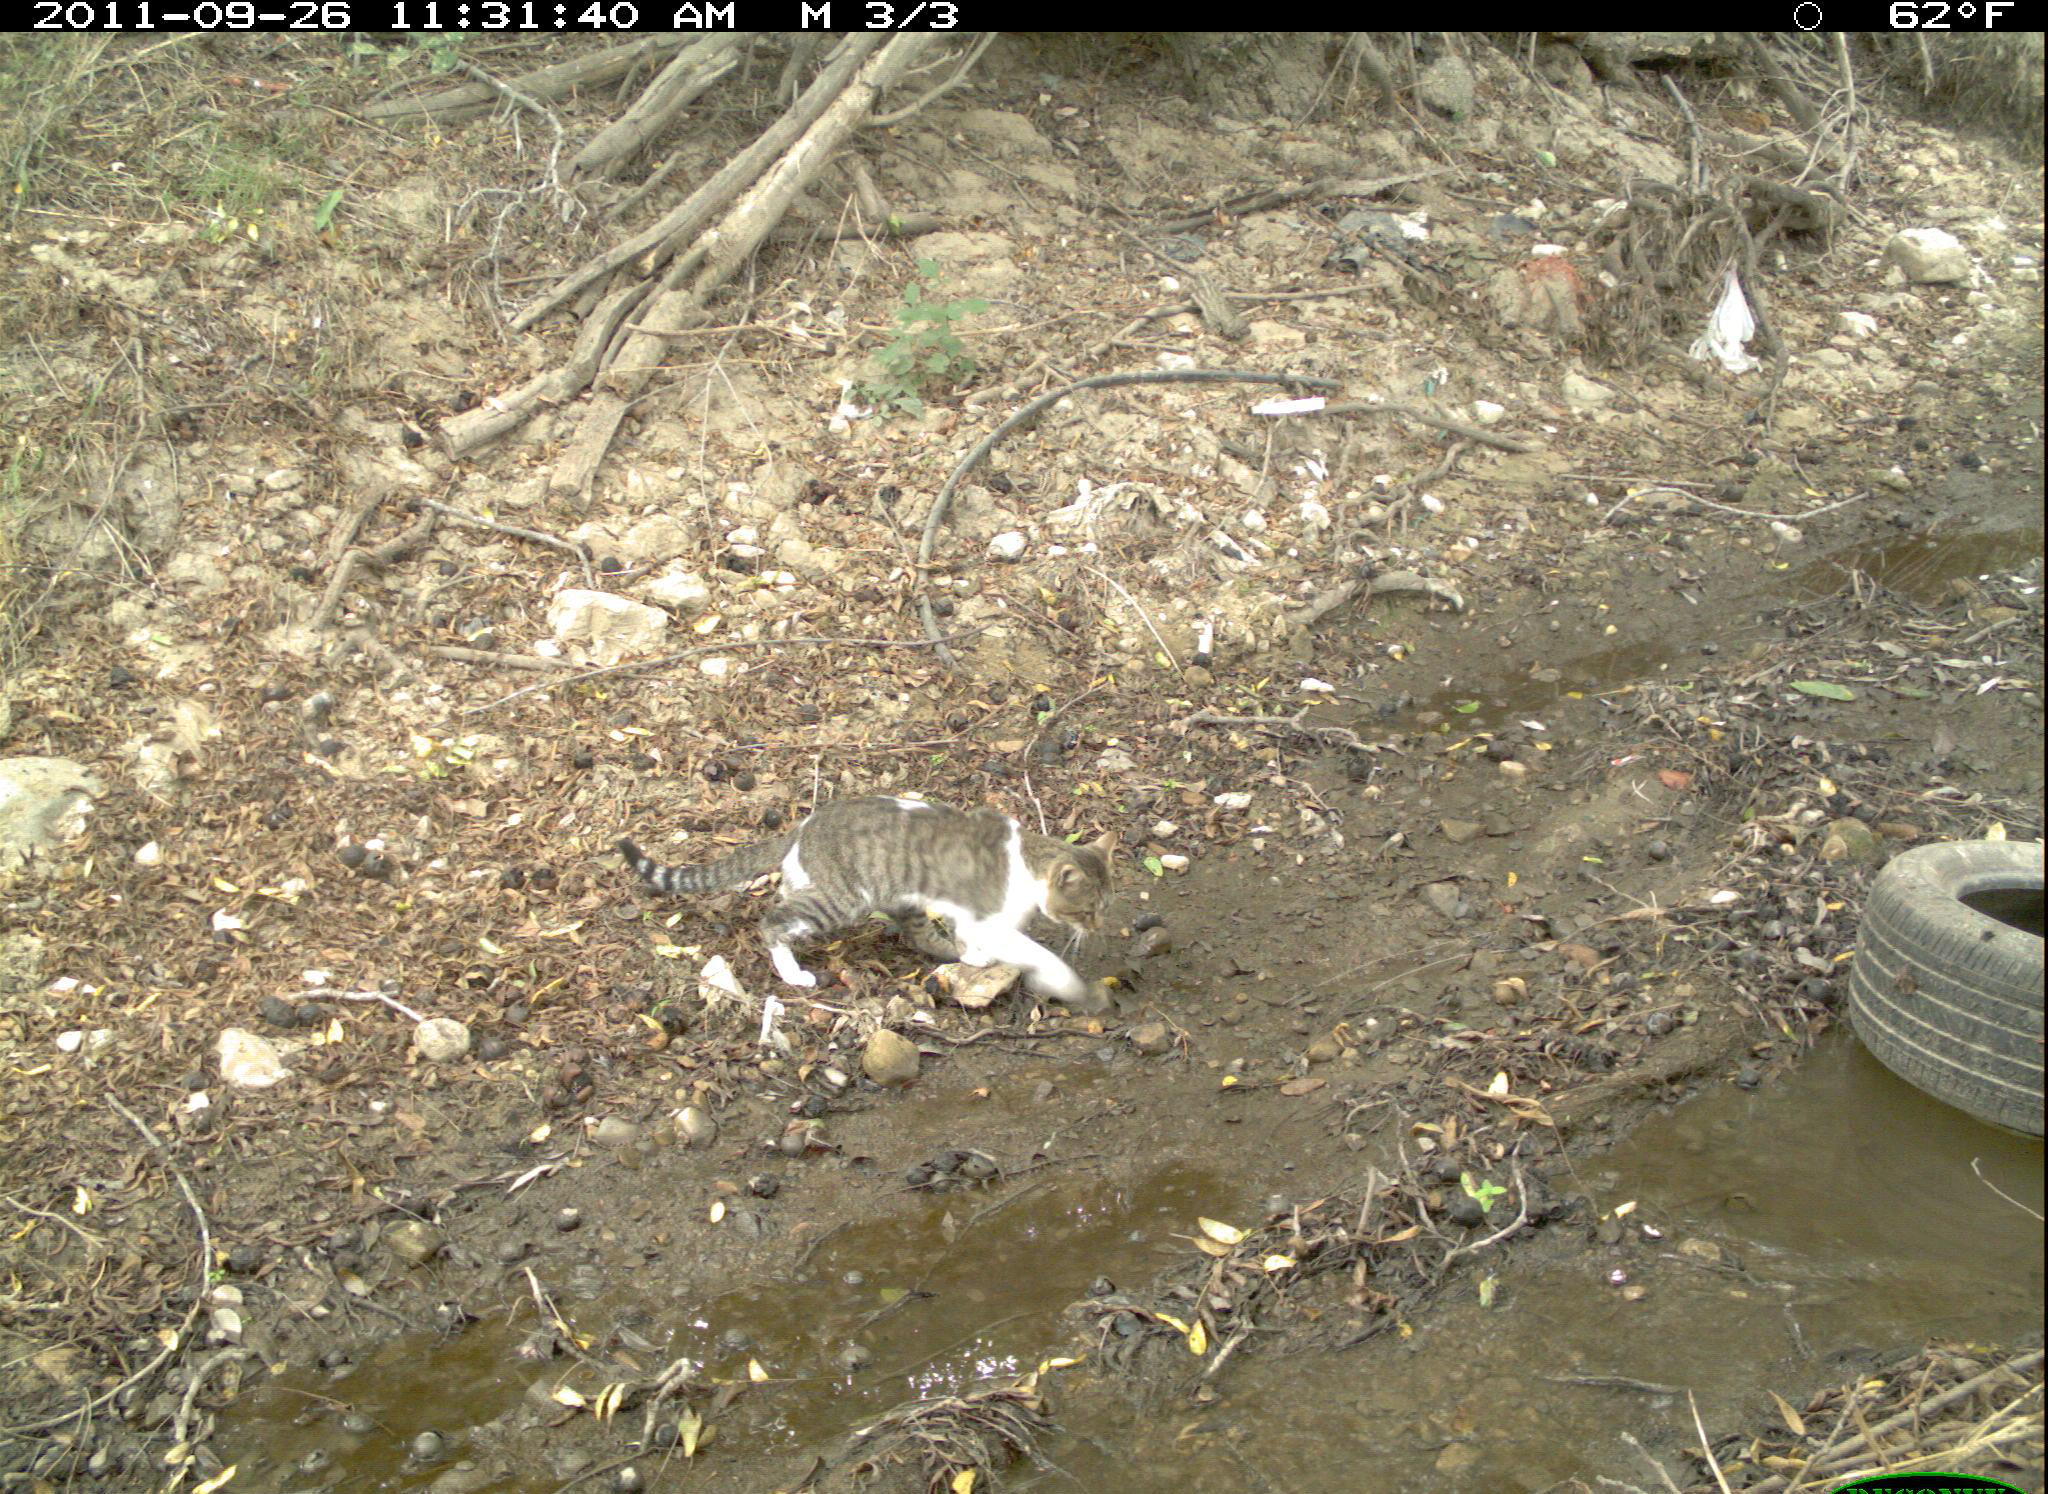

In [56]:
img

In [57]:
np.array(img).shape

(1494, 2048, 3)

In [58]:
box = df.iloc[idx, ]['bbox']

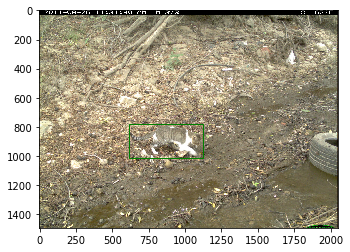

In [66]:

img = Image.open(img_path)
plt.imshow(img)


# Get the current reference
ax = plt.gca()

box_width = box[2]
box_height = box[3]


# Create a Rectangle patch
rect = Rectangle((box[0],box[1]),box_width,box_height,linewidth=1,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Make WildCam Dataset

In [ ]:
class WildcamDetectionDataset(Dataset):
    """Wildcam Image Dataset"""

    def __init__(self, label_file, root_dir, transform=None, transform_size=None, n_classes=23):
        self.labels = pd.read_csv(label_file)
        self.root_dir = root_dir
        self.transform = transform
        self.transform_size = transform_size
        self.n_classes = n_classes
        # Get images
        self.images = np.array(self.labels['file_name'])

        # Create one-hot encoded labels
        lab_vec = np.zeros((self.labels.shape[0], self.n_classes))
        for idx in range(lab_vec.shape[0]):
            lab_vec[idx][self.labels['category_id'][idx]] = 1
        self.labels = lab_vec
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """ Get an image"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image
        img = self.images[idx]
        image = Image.open(os.path.join(self.root_dir, img))
        label = self.labels[idx]

        # Apply transform
        if self.transform is not None:
            im_size = np.array(image).shape
            image = self.transform(image)
            
            label = self.resize_bb(label, im_size)

        return {'image': image, 'label': label}

In [95]:
# testing
root_dir = os.path.join(data_path, "eccv_18_cropped")

label_file = os.path.join(data_path, "eccv_18_annotation_files/train_annotations.json")
with open(label_file) as f:
    labels = json.load(f)
cats = pd.DataFrame(labels['categories'])

In [96]:
df = pd.DataFrame.from_dict(labels['annotations'])

In [97]:
df.head()
    

image_id  category_id  \
0  5a197af2-23d2-11e8-a6a3-ec086b02610b           10   
1  59fc7e52-23d2-11e8-a6a3-ec086b02610b           16   
2  5a2e130d-23d2-11e8-a6a3-ec086b02610b           10   
3  598ad0cf-23d2-11e8-a6a3-ec086b02610b            8   
4  598ad0cf-23d2-11e8-a6a3-ec086b02610b            8   

                                                bbox     id  
0  [317.44, 747.52, 261.11999999999995, 284.15999...  19688  
1           [0.0, 660.48, 381.44, 273.9200000000001]  43259  
2                    [1397.76, 458.24, 192.0, 192.0]  10268  
3  [989.44, 759.04, 262.4000000000001, 390.400000...   2721  
4       [33.28, 1118.72, 583.68, 375.03999999999996]   2722

In [98]:
df.shape

(14071, 4)

In [103]:
images = list(df['image_id'])
boxes = list(df['bbox'])
img_path = os.path.join(root_dir, images[0]+".jpg")

In [104]:
image = Image.open(img_path)
im_size = np.array(image).shape
im_size

(1494, 2048, 3)

In [105]:
box = boxes[0]

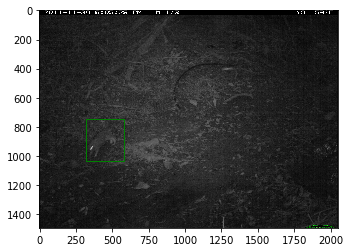

In [114]:
img = Image.open(img_path)
plt.imshow(img)


# Get the current reference
ax = plt.gca()

x1 = box[0]
y1 = box[1]
x2 = x1 + box[2]
y2 = y1 + box[3]


box_width = x2 - x1
box_height = y2 - y1
    

# Create a Rectangle patch
rect = Rectangle((x1, y1),box_width,box_height,linewidth=1,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

In [110]:
box

[317.44, 747.52, 261.11999999999995, 284.15999999999985]